In [3]:
from transformers import AutoImageProcessor, ResNetForImageClassification
from datasets import Image as HFImage, load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
train_ds = load_dataset("ILSVRC/imagenet-1k", streaming=False)
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

In [18]:
train_ds = load_dataset("ILSVRC/imagenet-1k", split="train", streaming=True)
train_ds = train_ds.cast_column("image", HFImage(decode=True))

In [19]:
tfm = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

# 3A) Batched mapper that handles PIL or raw bytes safely (robust)
def transform_batch(batch):
    out_imgs = []
    for img in batch["image"]:
        if isinstance(img, Image.Image):
            pil = img.convert("RGB")
        else:
            # if for some dataset 'image' is bytes/dict
            b = img["bytes"] if isinstance(img, dict) and "bytes" in img else img
            pil = Image.open(io.BytesIO(b)).convert("RGB")
        out_imgs.append(tfm(pil))
    return {"pixel_values": out_imgs, "label": batch["label"]}

In [20]:
train_ds = train_ds.map(transform_batch, batched=True)


In [21]:
sample = next(iter(train_ds.take(1)))
print(sample.keys())           # -> dict keys, e.g. 'pixel_values', 'label'
print(type(sample["pixel_values"]))  # torch.Tensor
print(sample["pixel_values"].shape)  # (3, 224, 224)
print(sample["label"])

dict_keys(['image', 'label', 'pixel_values'])
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
726


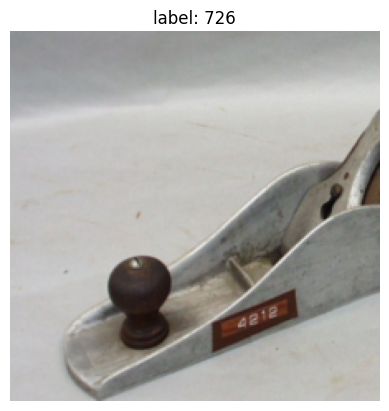

In [23]:
import matplotlib.pyplot as plt
import torch

img = sample["pixel_values"]
if torch.is_tensor(img):
    img_np = img.permute(1,2,0).numpy()
    # quick unnormalize visualization
    mean = (0.485, 0.456, 0.406); std = (0.229, 0.224, 0.225)
    img_np = (img_np * std) + mean
    plt.imshow(img_np.clip(0,1))
    plt.title(f"label: {sample['label']}")
    plt.axis("off")
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import torch

img = sample["pixel_values"][0]
# If it’s a tensor, convert to numpy and unnormalize
if torch.is_tensor(img):
    img = img.permute(1, 2, 0).numpy()
    img = (img * 0.229 + 0.485, img * 0.224 + 0.456, img * 0.406)  # roughly unnormalize
plt.imshow(img.clip(0,1))
plt.title(f"label: {sample['label'][0]}")
plt.show()


In [25]:
from model import resnet50

resnet_model = resnet50()
resnet_model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
resnet_sd = model.state_dict()
for k, v in resnet_sd.items():
    print(k, v.shape)

resnet.embedder.embedder.convolution.weight torch.Size([64, 3, 7, 7])
resnet.embedder.embedder.normalization.weight torch.Size([64])
resnet.embedder.embedder.normalization.bias torch.Size([64])
resnet.embedder.embedder.normalization.running_mean torch.Size([64])
resnet.embedder.embedder.normalization.running_var torch.Size([64])
resnet.embedder.embedder.normalization.num_batches_tracked torch.Size([])
resnet.encoder.stages.0.layers.0.shortcut.convolution.weight torch.Size([256, 64, 1, 1])
resnet.encoder.stages.0.layers.0.shortcut.normalization.weight torch.Size([256])
resnet.encoder.stages.0.layers.0.shortcut.normalization.bias torch.Size([256])
resnet.encoder.stages.0.layers.0.shortcut.normalization.running_mean torch.Size([256])
resnet.encoder.stages.0.layers.0.shortcut.normalization.running_var torch.Size([256])
resnet.encoder.stages.0.layers.0.shortcut.normalization.num_batches_tracked torch.Size([])
resnet.encoder.stages.0.layers.0.layer.0.convolution.weight torch.Size([64, 64, 1,